# Bone age using RadioGraphs

This note book is a base notebook to run a simple Convolutional Nerural Network on hand Radiographs for bone age predictions.

The code involves:
- setup of `Weights and Biases` library to track training.
- Overfitting the model on single batch (32) of images
- Usage of `Weights and Biases` Sweeps
- Save models related to a sweep and then load them

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.metrics import mean_absolute_error
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

import cv2
import wandb
from wandb.keras import WandbCallback

#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 
from utils import create_dataset_from_file

2023-02-11 16:32:38.968523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 16:32:39.321642: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-11 16:32:39.365333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-02-11 16:32:39.365353: I tensorflow/compiler/xla/stream_executor/cuda

In [2]:
IMG_SIZE = 256

In [3]:
# machine = "remote_system"
machine = "local"
# loading Data
    
### Set here the localtion of the data folder of your google drive
if machine == "remote_system":
    train_dir = "/server0/0/2022/mtirmizi/Documents/bone_data/Bone Age Training Set/"
    validation_dir = "/server0/0/2022/mtirmizi/Documents/bone_data/Bone Age Validation Set/"
    test_dir = "/server0/0/2022/mtirmizi/Documents/bone_data/Bone Age Test Set/"
else:
    train_dir = "/home/teemo/Documents/bone_data/Bone Age Training Set/"
    validation_dir = "/home/teemo/Documents/bone_data/Bone Age Validation Set/"
    test_dir = "/home/teemo/Documents/bone_data/Bone Age Test Set/"


### Train Data
train_image_dir = os.path.join( train_dir, "boneage-training-dataset")
train_df = pd.read_csv( os.path.join(train_dir,"train.csv") )

### Validation Data
validation_image_dir = os.path.join( validation_dir, "boneage-validation-dataset")
valid_df = pd.read_csv( os.path.join(validation_dir,"Validation Dataset.csv") )

### Test Data
test_image_dir = os.path.join(test_dir, "boneage-testing-dataset")
test_df = pd.read_excel(  os.path.join(test_dir, "test.xlsx"))

# Preprocess Train Dataset
train_df["male"] = train_df["male"].astype(int)

# Preprocess Validation Dataset
valid_df = valid_df.rename(columns={'Bone Age (months)': 'boneage', 'Image ID': 'id'})
valid_df["male"] = valid_df["male"].astype(int)

# Preprocess Test Dataset
test_df = test_df.rename(columns={'Ground truth bone age (months)': 'boneage', 'Case ID': 'id'})
test_df["male"] = test_df['Sex'].replace(['M', 'F'], [1, 0])
test_df = test_df.drop(columns=["Sex"])


# Appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x) + '.png')
valid_df['id'] = valid_df['id'].apply(lambda x: str(x) + '.png')
test_df['id'] = test_df['id'].apply(lambda x: str(x) + '.png') 

# Create Image paths. Will be needed in tensorflow Dataset API
train_df['img_path'] = train_df['id'].apply(lambda x: os.path.join(train_image_dir, str(x)) )
valid_df['img_path'] = valid_df['id'].apply(lambda x: os.path.join(validation_image_dir, str(x)) )
test_df['img_path'] = test_df['id'].apply(lambda x: os.path.join(test_image_dir, str(x)) )

#mean age is
mean_bone_age = train_df['boneage'].mean()

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df.loc[:, 'bone_age_z'] = (train_df['boneage'] - mean_bone_age) / std_bone_age

# Similarly z score for Validation & testing data
valid_df.loc[:, "bone_age_z"] = (valid_df["boneage"] - mean_bone_age) / std_bone_age
test_df.loc[:, 'bone_age_z'] = (test_df['boneage'] - mean_bone_age) / std_bone_age


In [4]:
train_df.head()
train_dataset = create_dataset_from_file(train_df["img_path"], train_df["male"].to_numpy().reshape(-1, 1), train_df["bone_age_z"], use_gender=False, batch_size=32)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-11 16:32:44.343056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teemo/anaconda3/envs/ds/lib/python3.10/site-packages/cv2/../../lib64:/app/lib
2023-02-11 16:32:44.343336: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-11 16:32:44.343385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-02-11 16:32:44.344698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Ten

In [5]:
for train_img in train_dataset:
    # print(train_img[0][0].shape)
    # print(train_img[0])
    break

In [6]:
### Statistics about the data
print( f"Images in the training set: {len(train_df)}" )
print( f"Images in the validation set: {len(valid_df)}" )
print( f"Images in the test set: {len(test_df)}" )

Images in the training set: 12611
Images in the validation set: 1425
Images in the test set: 200


(1651, 1622, 3)


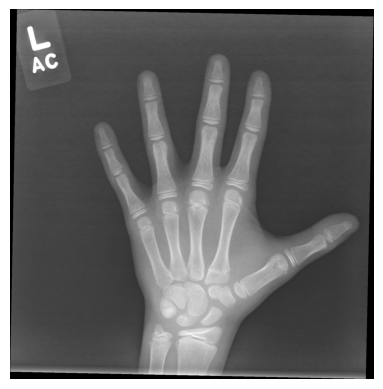

(1779, 1813, 3)


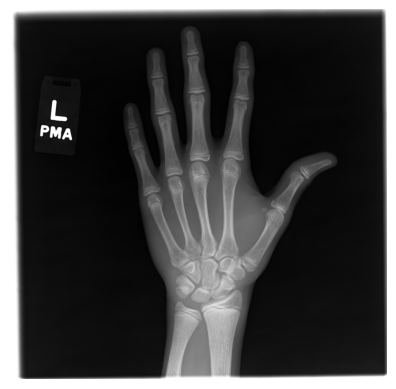

(1294, 905, 3)


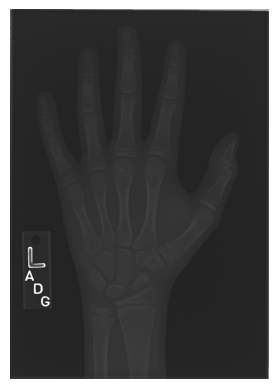

(1616, 1616, 3)


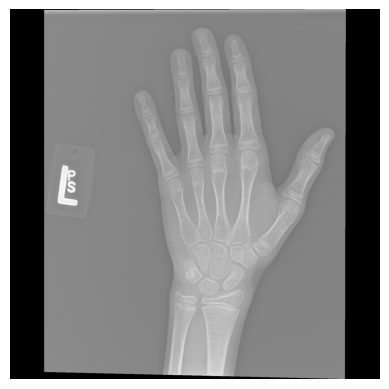

In [56]:
for img_path, boneage, male in train_df[['img_path','boneage','male']].sample(4).values:

    # img = mpimg.imread(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    plt.imshow(img)
    # plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, male))
    print(img.shape)
    plt.axis('off')
    plt.show()

In [116]:
np.random

TypeError: 'module' object is not callable

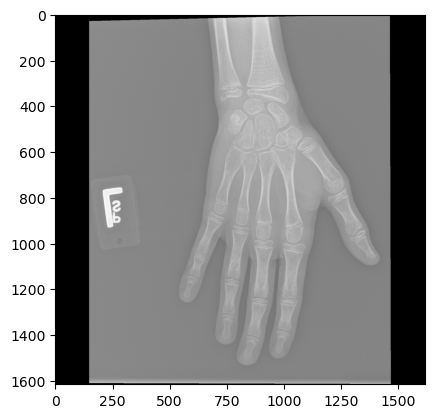

In [86]:
img
# data_aug = tf.keras.Sequential([
#     # tf.keras.layers.Resizing(256, 256),
#     tf.keras.layers.RandomFlip("horizontal_and_vertical")
# ])
data_aug = tf.keras.layers.RandomFlip("horizontal_and_vertical")

# Add the image to a batch.
img2 = tf.cast(tf.expand_dims(img, 0), tf.float32)
# img2 = img


# img2 = data_aug(img2)
img2 = tf.image.stateless_random_flip_up_down(img2, seed = seed)
plt.imshow(img2[0].numpy().astype("uint8"), cmap="gray")

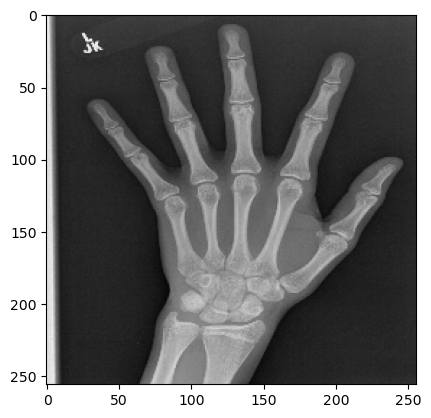

In [195]:
import cv2

def load_image(img_name, img_size=IMG_SIZE):
    """
    Returns numpy.ndarray (img_size, img_size, 3)
    """
    if isinstance(img_name, bytes):
        img_name = img_name.decode()
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    # Want numpy array to have "float32" and not "uint8" 
    img = np.array( cv2.resize(img, (img_size, img_size)), dtype="float32" )

    return img


def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.0

## Define Data augmentation
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical")
# #   tf.keras.layers.RandomRotation(0.2),
# ])
# data_augmentation = tf.keras.layers.RandomFlip("horizontal_and_vertical")
def data_augmentation(image):
    seed = np.random.rand(2) * 4
    image = tf.image.stateless_random_flip_left_right(image, seed)
    seed = np.random.rand(2) * 4
    image = tf.image.stateless_random_flip_up_down(image, seed)
    return image

# Create a Dataset object
train_image_data = tf.data.Dataset.from_tensor_slices( train_df["img_path"]  )

# allows to injest tensor op file_paths by a python function
py_func = lambda file_name: (tf.numpy_function(load_image, [file_name, IMG_SIZE], tf.float32))
train_image_data = train_image_data.map(py_func, num_parallel_calls=os.cpu_count())

# Normalize the images, meaning bring their values range between 0 and 1
train_image_data = train_image_data.map(normalize_img, num_parallel_calls=os.cpu_count())

# # Batch
# train_image_data = train_image_data.batch(32)

# map the Data Augmentation function
# train_image_data = train_image_data.map(lambda x: data_augmentation(x, training=True), num_parallel_calls=os.cpu_count())
# train_image_data = train_image_data.map(data_augmentation, num_parallel_calls=os.cpu_count())
train_image_data = train_image_data.map(data_augmentation)

for img in train_image_data:
    plt.imshow(img)
    break

### Normalize the label/ target/ bone age prediction value/ y
target column: `bone_age_z`

In [9]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()
print(f"Standard Deviation {std_bone_age}")

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age) / (std_bone_age)

print(train_df.head())

MAX age: 216 months
MIN age: 4 months
mean: 103.735
median: 106.0
Standard Deviation 50.05097677750065
         id  boneage   male  bone_age_z
0  1377.png      180  False    1.523746
1  1378.png       12  False   -1.832831
2  1379.png       94  False   -0.194502
3  1380.png      120   True    0.324969
4  1381.png       82  False   -0.434257


In [10]:
# Test tensorflow resizing
resizer = tf.keras.layers.Resizing(256, 256)
X = tf.random.normal((1, 512, 512, 3), dtype=tf.dtypes.float32)
print(f"Go from shape (256, 256) -> {resizer(X).shape}")

Go from shape (256, 256) -> (1, 256, 256, 3)


2022-12-15 11:44:14.065509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-15 11:44:14.065535: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 11:44:14.065563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-12-15 11:44:14.065875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
resizer = tf.keras.layers.Resizing(256, 256)
img_size = 256
#train data generator
train_data_generator = ImageDataGenerator()

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = '/home/teemo/Documents/bone_data/Bone Age Training Set/boneage-training-dataset/',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 1,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))


Found 200 validated image filenames.


In [12]:
# TODO figure out what does # ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples) 
# do

# train_df = train_df.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# train_df = train_df.batch(32)
# train_df = train_df.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 